# Sparkles - HCIPy Simultions

In [26]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

# These modules are used for animating some of the graphs in our notebook.
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

## HCIPY Tutorial

Defining a few parameters according to the MagAO-X specifications:
<br> The Magallen telescope has a diameter of <b>6.5 meters </b>
<br> We will use a sensing wavelength of <b>842nm.</b> 
<br> A zero magnitude star will have flux of <b> 3.9E10 </b> photons/s.

In [2]:
wavelength_wfs = 842.0E-9
telescope_diameter = 6.5
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0

For the pyramid wavefront sensor (and the other Fourier based wavefront sensors), we need to create a <b> grid on which the input wavefront is defined</b> and a grid that defines the output sampling. 
<br> For our case we can use an input grid of 56 pixels across the Magellan pupil. 
<br> The pyramid wavefront sensor of MagAO-X is sampled with 56 pixels across the pupil and has a distance of 60 pixels between the pupils. 
<br> The OCAM2K camera has a total of 120x120 pixels after 2x2 binning. 
<br> For this tutorial we will sample the out wavefront on 120x120 pixels and we will ignore the binning effects.

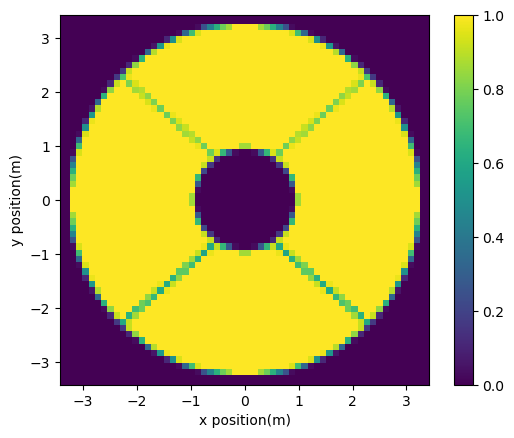

In [3]:
# Creating Magellan Pupil
num_pupil_pixels = 60
pupil_grid_diameter = 60/56 * telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
pwfs_grid = make_pupil_grid(120, 2 * pupil_grid_diameter)
magellan_aperture = evaluate_supersampled(make_magellan_aperture(), pupil_grid, 6)

# Showing pupil grid
imshow_field(magellan_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

Let’s make our deformable mirror. 
<br> MagAO-X uses a <b>2k-MEMS DM</b> of Boston Micromachines. 
<br> The influence functions of the DM are nearly gaussian. => We will therefore make a DM with <b>Gaussian influence functions. </b>
<br> There are <b>50 actuators</b> across the pupil. But for speed purposes we will limit the number of actuators to <b>10 across</b> the pupil.

In [4]:
# Making deformable mirror
num_actuators_across_pupil = 50
actuator_spacing = telescope_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing)
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

Now we are going to make the optics of the pyramid wavefront sensor and the camera. Because the OCAM2K is a very high performance EMCCD we will simulate this detector as a noiseless detector.

In [5]:
pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=pupil_grid_diameter, pupil_diameter=telescope_diameter, wavelength_0=wavelength_wfs, q=3)
camera = NoiselessDetector(pwfs_grid)
modulation = 3
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, modulation)

In [6]:
wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1
#camera.integrate(pwfs.forward(wf), 1) #for a static PWFS
# Eden: modulation needs an averaging function for all steps?
wfs_pywfs = mpwfs.forward(wf)

In [7]:
def mod_forward_int(wfs_pywfs):
    """This iterates on wfs and returns an average of the power
    """
    image_final = 0
    for e, wfs_i in enumerate(wfs_pywfs):
        image_final += wfs_i.power 
    return image_final / ( e + 1) #/num_mod_STEPS

We are going to use a linear reconstruction algorithm for the wavefront estimation and for that we will need to measure the reference response of a perfect incoming wavefront. To create this we create an unabberated wavefront and propagate it through the pyramid wavefront sensor. Then we will integrate the response with our camera.

The final reference will be divided by the total sum to normalize the wavefront sensor response. Doing this consequently for all exposures will make sure that we can use this reference for arbitrary exposure times and photon fluxes.

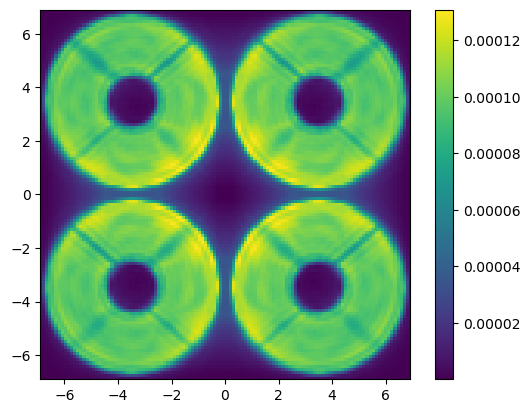

In [8]:
# making a reference image without any aberrations
image_ref = mod_forward_int(wfs_pywfs)
imshow_field(image_ref)
plt.colorbar()
plt.show()

For the linear reconstructor we need to now the interaction matrix, which tells us how the pyramid wavefront sensor responds to each actuator of the deformable mirror. This can be build by sequentially applying a positive and negative voltage on a single actuator. The difference between the two gives us the actuator response.

We will use the full image of the pyramid wavefront sensor for the reconstruction, so we do not compute the normalized differences between the pupils.

In [9]:
# Create the interaction matrix
probe_amp = 0.01 * wavelength_wfs
slopes = []

wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1

for ind in range(num_modes):
    if ind % 10 == 0:
        print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    slope = 0
    deformable_mirror.flatten()
    # Probe the phase response
    for s in [1, -1]:
        #amp = np.zeros((num_modes,))
        #amp[ind] = s * probe_amp
        deformable_mirror.actuators[ind] = s * probe_amp

        dm_wf = deformable_mirror.forward(wf)
        #wfs_wf = pwfs.forward(dm_wf)
        #camera.integrate(wfs_wf, 1)
        #image = camera.read_out()
        #image /= np.sum(image)

        mwfs_wf = mpwfs.forward(dm_wf)
        image = mod_forward_int(mwfs_wf)

        slope += s * (image-image_ref)/(2 * probe_amp)

    slopes.append(slope)

slopes = ModeBasis(slopes)

Measure response to mode 1 / 2500
Measure response to mode 11 / 2500
Measure response to mode 21 / 2500
Measure response to mode 31 / 2500
Measure response to mode 41 / 2500
Measure response to mode 51 / 2500
Measure response to mode 61 / 2500
Measure response to mode 71 / 2500
Measure response to mode 81 / 2500
Measure response to mode 91 / 2500
Measure response to mode 101 / 2500
Measure response to mode 111 / 2500
Measure response to mode 121 / 2500
Measure response to mode 131 / 2500
Measure response to mode 141 / 2500
Measure response to mode 151 / 2500
Measure response to mode 161 / 2500
Measure response to mode 171 / 2500
Measure response to mode 181 / 2500
Measure response to mode 191 / 2500
Measure response to mode 201 / 2500
Measure response to mode 211 / 2500
Measure response to mode 221 / 2500
Measure response to mode 231 / 2500
Measure response to mode 241 / 2500
Measure response to mode 251 / 2500
Measure response to mode 261 / 2500
Measure response to mode 271 / 2500
Mea

KeyboardInterrupt: 

### Restart normal DM work

The matrix that we build by poking the actuators can be used to transform a DM pattern into the wavefront sensor response. For wavefront reconstruction we want to invert this. We currently have,
With
being the response of the wavefront sensor, the interaction matrix and

the incoming pertubation on the DM. This equation can be solved in a linear least squares sense,
The matrix can be found by applying a pseudo-inverse operation on the matrix . A regularized version of this is implemented in HCIpy with the inverse_tikhonov function.

In [52]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)

Initialize our wavefront and setup the propagator for evaluation of the PSF.

In [53]:
spatial_resolution = wavelength_wfs / telescope_diameter
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
norm = prop(wf).power.max()



To have something to measure and correct we put a random shape on the DM.

In [54]:
deformable_mirror.random(0.2 * wavelength_wfs)

Now lets setup the parameters of our AO system. The first step is to choose an integration time for the exposures. We choose an exposure time of 1 ms, so we are running our AO system at 1 kHz. For the controller we choose to use a leaky integrator which has been proven to be a robust controller. The leaky integrator has two parameters, the leakage and the gain.

In [55]:
# Choosing an exposure time!
delta_t = 1E-3
leakage = 0.0
gain = 0.5

Let’s check the current PSF that is created by the deformed mirror.

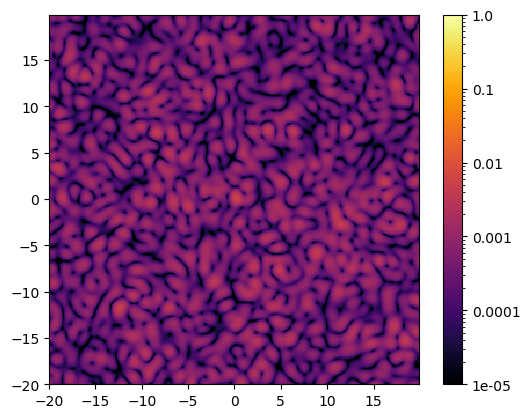

In [56]:
PSF_in = prop(deformable_mirror.forward(wf)).power

imshow_psf(PSF_in / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)
plt.show()

### Closed loop system

In [71]:
def create_closed_loop_animation():

    PSF = prop(deformable_mirror(wf)).power

    fig = plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    plt.title(r'DM surface shape ($\mathrm{\mu}$m)')
    im1 = imshow_field(deformable_mirror.surface/(1e-6), vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title('Wavefront sensor output')
    im2 = imshow_field(image_ref, pwfs_grid)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title('Science image plane')
    im3 = imshow_field(np.log10(PSF / norm), vmax=0, vmin=-5, cmap='inferno')
    plt.colorbar()

    plt.close(fig)

    def animate(t):
        wf_dm = deformable_mirror.forward(wf)
        wf_pyr = mpwfs.forward(wf_dm)

        wfs_image = mod_forward_int(wf_pyr)

        diff_image = wfs_image - image_ref
        deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image)

        phase = magellan_aperture * deformable_mirror.surface
        phase -= np.mean(phase[magellan_aperture>0])

        psf = prop(deformable_mirror(wf)).power

        im1.set_data(*pupil_grid.separated_coords, (magellan_aperture * deformable_mirror.surface).shaped / 1e-6)
        im2.set_data(*pwfs_grid.separated_coords, wfs_image.shaped)
        im3.set_data(*focal_grid.separated_coords, np.log10(psf.shaped / norm))

        return [im1, im2, im3]

    num_time_steps=21
    time_steps = np.arange(num_time_steps)
    anim = animation.FuncAnimation(fig, animate, time_steps, interval=160, blit=True)
    return HTML(anim.to_jshtml(default_mode='loop'))

create_closed_loop_animation()


## Fourier Transform basis

Creating a basis of fourier modes

In [11]:
# Making a fourier mode DM
fourier_grid = make_pupil_grid(num_actuators_across_pupil, 2*np.pi*num_actuators_across_pupil/telescope_diameter)
fourier_grid = fourier_grid.rotate(0.6)  #number in radians) # rotating? 
fourier_influence_funcs = make_fourier_basis(pupil_grid, fourier_grid)
fourier_deformable_mirror = DeformableMirror(fourier_influence_funcs)

In [12]:
# fourier Modes interaction matrix:

# Create the interaction matrix
probe_amp = 0.01 * wavelength_wfs
f_slopes = []

wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1

for ind in range(num_modes):
    if ind % 10 == 0:
        print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    f_slope = 0
    fourier_deformable_mirror.flatten()
    # Probe the phase response
    for s in [1, -1]:
        #amp = np.zeros((num_modes,))
        #amp[ind] = s * probe_amp
        fourier_deformable_mirror.actuators[ind] = s * probe_amp

        dm_wf = fourier_deformable_mirror.forward(wf)
        #wfs_wf = pwfs.forward(dm_wf)
        #camera.integrate(wfs_wf, 1)
        #image = camera.read_out()
        #image /= np.sum(image)

        mwfs_wf = mpwfs.forward(dm_wf)
        image = mod_forward_int(mwfs_wf)

        f_slope += s * (image-image_ref)/(2 * probe_amp)

    f_slopes.append(f_slope)

f_slopes = ModeBasis(f_slopes)

Measure response to mode 1 / 2500
Measure response to mode 11 / 2500
Measure response to mode 21 / 2500
Measure response to mode 31 / 2500
Measure response to mode 41 / 2500
Measure response to mode 51 / 2500
Measure response to mode 61 / 2500
Measure response to mode 71 / 2500
Measure response to mode 81 / 2500
Measure response to mode 91 / 2500
Measure response to mode 101 / 2500
Measure response to mode 111 / 2500
Measure response to mode 121 / 2500
Measure response to mode 131 / 2500
Measure response to mode 141 / 2500
Measure response to mode 151 / 2500
Measure response to mode 161 / 2500
Measure response to mode 171 / 2500
Measure response to mode 181 / 2500
Measure response to mode 191 / 2500
Measure response to mode 201 / 2500
Measure response to mode 211 / 2500
Measure response to mode 221 / 2500
Measure response to mode 231 / 2500
Measure response to mode 241 / 2500
Measure response to mode 251 / 2500
Measure response to mode 261 / 2500
Measure response to mode 271 / 2500
Mea

KeyboardInterrupt: 

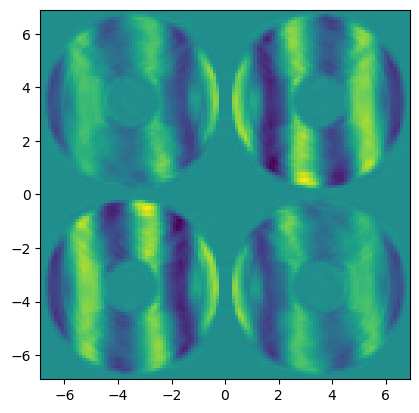

In [47]:
imshow_field(f_slopes.transformation_matrix[:,30], pwfs_grid)

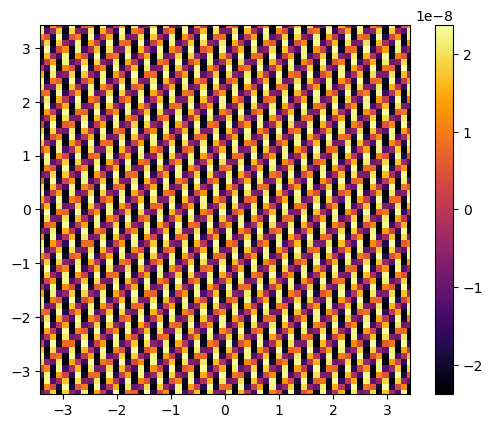

In [48]:
#showing dm command
imshow_field(fourier_deformable_mirror.opd, cmap='inferno')
plt.colorbar()

#as of right now too faint

In [49]:
#fourier_deformable_mirror.actuators[25] = 0.15 * wavelength_wfs #this is too strong
fourier_deformable_mirror.actuators[25] = 0.05 * wavelength_wfs

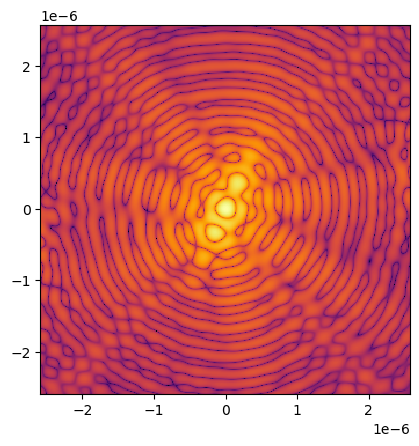

In [50]:
spatial_resolution = wavelength_wfs / telescope_diameter
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
psf = prop(fourier_deformable_mirror(wf) ).power
imshow_field(np.log10(psf), cmap='inferno')

## Sparkle Code

In [ ]:
#example code:
#act_grid = make_pupil_grid(nact, telescope_diameter)
#pattern_sparkle = 0.1 * np.cos(2 * np.pi * act_grid.x * 15 / telescope_diameter + np.pi)

In [57]:
# creating an actuator pattern from hcipy

def genSpark(nact, telescope_diameter, seperation=15, m_angle = 0.0, angleOff = 28.0, amp = 0.01, m_cross = True):
    act_grid = make_pupil_grid(nact, telescope_diameter).rotate(angleOff - m_angle) # DM based on real params

    # converting from MagAO-X param (um) to HCIPY OPD values (m)
    m_amp = amp * 10e-6

    # Like Jared's code, sine and cosine, but explicitly for x and y
    pattern_mx = np.cos(2 * np.pi * act_grid.x * seperation / telescope_diameter)
    pattern_my = np.cos(2 * np.pi * act_grid.y * seperation / telescope_diameter)

    pattern_nx = np.sin(2 * np.pi * act_grid.x * seperation / telescope_diameter)
    pattern_ny = np.sin(2 * np.pi * act_grid.y * seperation / telescope_diameter)

    #### Sparkle four counts #### 

    # Spark 0: a cross of sine and cosine
    spark0 = (pattern_mx + pattern_ny)
    if m_cross:
        spark0 -= (-1*pattern_nx + pattern_my)
    spark0 *= m_amp
    # Spark 1: equal and opposite to spark0
    spark1 = -spark0

    # Spark 2: 90 deg shift from spark0
    spark2 = -1* pattern_mx + pattern_ny
    if m_cross:
        spark2 -= (-1*pattern_nx + pattern_my)
    spark2 *= m_amp
    # Spark 3: equal and opposie to spark2
    spark3 = -spark2

    return spark0, spark1, spark2, spark3

In [58]:
# testing:
sparks_list = genSpark(num_actuators_across_pupil, telescope_diameter)

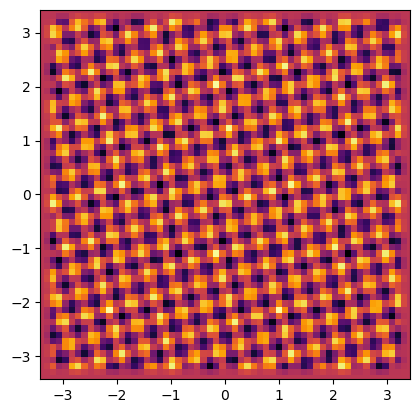

In [33]:
deformable_mirror.actuators = sparks_list[0]
#imshow_field(deformable_mirror.surface, cmap='inferno')
imshow_field(magellan_aperture * deformable_mirror.opd, cmap='inferno')

In [25]:
## Closed loop with sparkles

def create_closed_loop_animation_sparkles():

    PSF = prop(deformable_mirror(wf)).power

    fig = plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    plt.title(r'DM surface shape ($\mathrm{\mu}$m)')
    im1 = imshow_field(deformable_mirror.surface/(1e-6), vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title('Wavefront sensor output')
    im2 = imshow_field(image_ref, pwfs_grid)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title('Science image plane')
    im3 = imshow_field(np.log10(PSF / norm), vmax=0, vmin=-5, cmap='inferno')
    plt.colorbar()

    plt.close(fig)

    def animate(t):
        wf_dm = deformable_mirror.forward(wf)
        wf_pyr = mpwfs.forward(wf_dm)

        wfs_image = mod_forward_int(wf_pyr)

        diff_image = wfs_image - image_ref
        deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image) + sparks_list[t%4] 

        phase = magellan_aperture * deformable_mirror.surface
        phase -= np.mean(phase[magellan_aperture>0])

        psf = prop(deformable_mirror(wf) ).power

        im1.set_data(*pupil_grid.separated_coords, (magellan_aperture * deformable_mirror.surface).shaped / 1e-6)
        im2.set_data(*pwfs_grid.separated_coords, wfs_image.shaped)
        im3.set_data(*focal_grid.separated_coords, np.log10(psf.shaped / norm))

        return [im1, im2, im3]

    num_time_steps=21
    time_steps = np.arange(num_time_steps)
    anim = animation.FuncAnimation(fig, animate, time_steps, interval=160, blit=True)
    return HTML(anim.to_jshtml(default_mode='loop'))

create_closed_loop_animation_sparkles()

NameError: name 'prop' is not defined

## Testing sim_sparkle.py

In [10]:
import sim_sparkle as smsp
from importlib import reload

In [20]:
reload(smsp)

<module 'sim_sparkle' from '/home/eden/code/sim_sparkle.py'>

In [11]:
#setup
pupil_grid, pwfs_grid, magellan_aperture = smsp.create_mag_pupil()
deformable_mirror = smsp.create_DM(pupil_grid)
mpwfs, camera = smsp.create_mod_PWFS(pupil_grid, pwfs_grid)

In [21]:
#wfs
wf = smsp.create_wf(magellan_aperture)
wfs_pywfs = smsp.create_pwfs(mpwfs, wf)
image_ref = smsp.mod_forward_int(wfs_pywfs)

In [24]:
#int mat
slopes = smsp.create_int_mat_mod(deformable_mirror, wf, mpwfs, image_ref)

Measure response to mode 1 / 2500
Measure response to mode 11 / 2500
Measure response to mode 21 / 2500
Measure response to mode 31 / 2500
Measure response to mode 41 / 2500
Measure response to mode 51 / 2500
Measure response to mode 61 / 2500
Measure response to mode 71 / 2500
Measure response to mode 81 / 2500
Measure response to mode 91 / 2500
Measure response to mode 101 / 2500
Measure response to mode 111 / 2500
Measure response to mode 121 / 2500
Measure response to mode 131 / 2500
Measure response to mode 141 / 2500
Measure response to mode 151 / 2500
Measure response to mode 161 / 2500
Measure response to mode 171 / 2500
Measure response to mode 181 / 2500
Measure response to mode 191 / 2500
Measure response to mode 201 / 2500
Measure response to mode 211 / 2500
Measure response to mode 221 / 2500
Measure response to mode 231 / 2500
Measure response to mode 241 / 2500
Measure response to mode 251 / 2500
Measure response to mode 261 / 2500
Measure response to mode 271 / 2500
Mea

In [23]:
sparks_list = smsp.genSpark() # takes in specific params, will iter on this